In [83]:
from cuesdk import CueSdk
import time
from PIL import ImageGrab
from PIL import Image
import pandas as pd
import numpy as np

In [159]:
sdk = CueSdk()
sdk.connect()

devices = sdk.get_devices()
device_list = dict()
mouse_on_right = True

for i in range(sdk.get_device_count()):
    device_type = str(devices[i].type)
    if 'Mouse' in device_type:
        device_list.update({'mouse': i})
    if 'Keyboard' in device_type:
        device_list.update({'keyboard': i})

def get_available_leds():
    leds = dict()
    device_count = sdk.get_device_count()
    for device_index in range(device_count):
        led_positions = sdk.get_led_positions_by_device_index(device_index)
        leds.update({device_index:led_positions})
    return leds

In [154]:
# get all led positions, add flag for device type
df = pd.DataFrame([],columns=['x','y','device_type'])
for d in device_list:
    
    df_temp = pd.DataFrame.from_dict(leds[device_list[d]],orient='index',columns=['x','y'])
    df_temp['device_type'] = d
    df = df.append(df_temp)

# if set up contains a mouse, adjust led coords to be left or right of keyboard
if 'mouse' in df['device_type'].values:    
    keyboard_length = df[df['device_type']=='keyboard']['x'].max()
    mouse_length = df[df['device_type']=='mouse']['x'].max()
    
    if mouse_on_right:
        df['modify_x'] = [keyboard_length if d=='mouse' else 0 for d in df['device_type']]
        df['x'] = df['x']+df['modify_x']
    else:
        df['modify_x'] = [mouse_length if d=='keyboard' else 0 for d in df['device_type']]
        df['x'] = df['x']+df['modify_x']
    
    df = df.drop(['modify_x'],axis=1)
    
# sdk function expects coordinates in tuples    
df['xy'] = list(zip(df['x'],df['y']))
# target size to reshape on screen image to, based on coords of keyboard/mouse
image_size = (int(df['x'].max()+1),int(df['y'].max()+1))

In [155]:
# main

sdk.request_control()
print("Press ctrl+c to stop")
try: 
    while True:
        # take a screenshot
        image = ImageGrab.grab()
        # downscale
        image = image.resize((16,8),resample=Image.BILINEAR)
        # upscale
        image = image.resize(image_size,resample=Image.NEAREST)

        df['rgb'] = df['xy'].apply(image.getpixel)
        
        for d in device_list:
            rgb = df[df['device_type']==d].to_dict()['rgb']
            sdk.set_led_colors_buffer_by_device_index(device_list[d],rgb)
            
        sdk.set_led_colors_flush_buffer()
        time.sleep(1/30)
except KeyboardInterrupt:
    print("Stopped")
    sdk.release_control()

Press ctrl+c to stop
Stopped


# Explaination

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

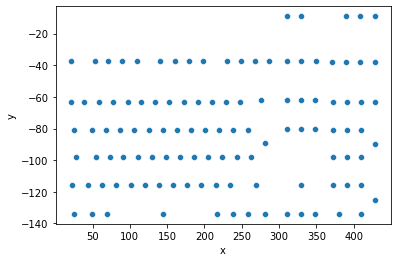

In [166]:
df_keys = df[df['device_type']=='keyboard']
sns.scatterplot(x=df_keys['x'],y=-1*df_keys['y']);

Led positions are shown in graph, but mutiplied y coords by -1 to show as usually viewed. (origin of the coordinate system is on lower left of keyboard)
You can see the space bar at approx (150,-135), ESC button at approx (10,-40)